SECTION 1: Load Data + Basic Cleanup + Target Creation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("student_performance_updated_1000.csv")

# ----- Create Pass/Fail Target -----
df["PassFail"] = (df["FinalGrade"] >= 70).astype(int)

# ----- Drop Unnecessary Columns -----
cols_to_drop = ["StudentID", "Name", "Study Hours", "Attendance (%)"]
df = df.drop(columns=cols_to_drop, errors="ignore")

# Preview cleaned dataframe
df.head()


,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,FinalGrade,Online Classes Taken,PassFail
0,Male,85.0,15.0,78.0,1.0,High,80.0,False,1
1,Female,90.0,20.0,85.0,2.0,Medium,87.0,True,1
2,Male,78.0,10.0,65.0,0.0,Low,68.0,False,0
3,Male,92.0,25.0,90.0,3.0,High,92.0,False,1
4,Female,NaN,18.0,82.0,2.0,Medium,85.0,True,1


SECTION 2: Check for Missing Values

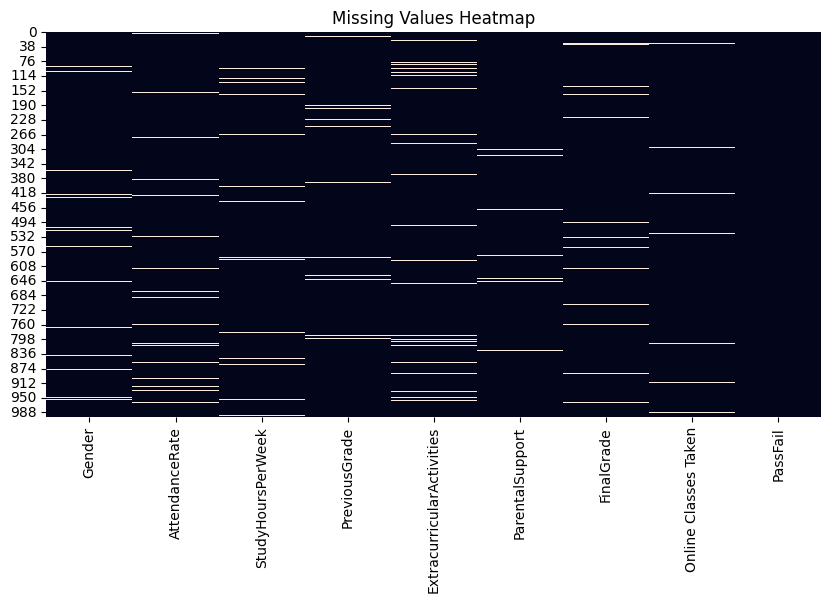

In [2]:
# Missing value summary
df.isnull().sum()

# Visualize missing values
plt.figure(figsize=(10,5))
sns.heatmap(df.isnull(), cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

SECTION 3: Basic EDA

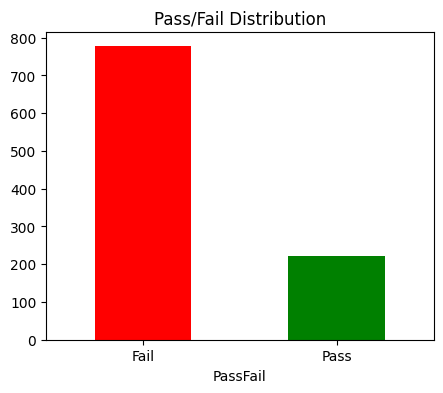

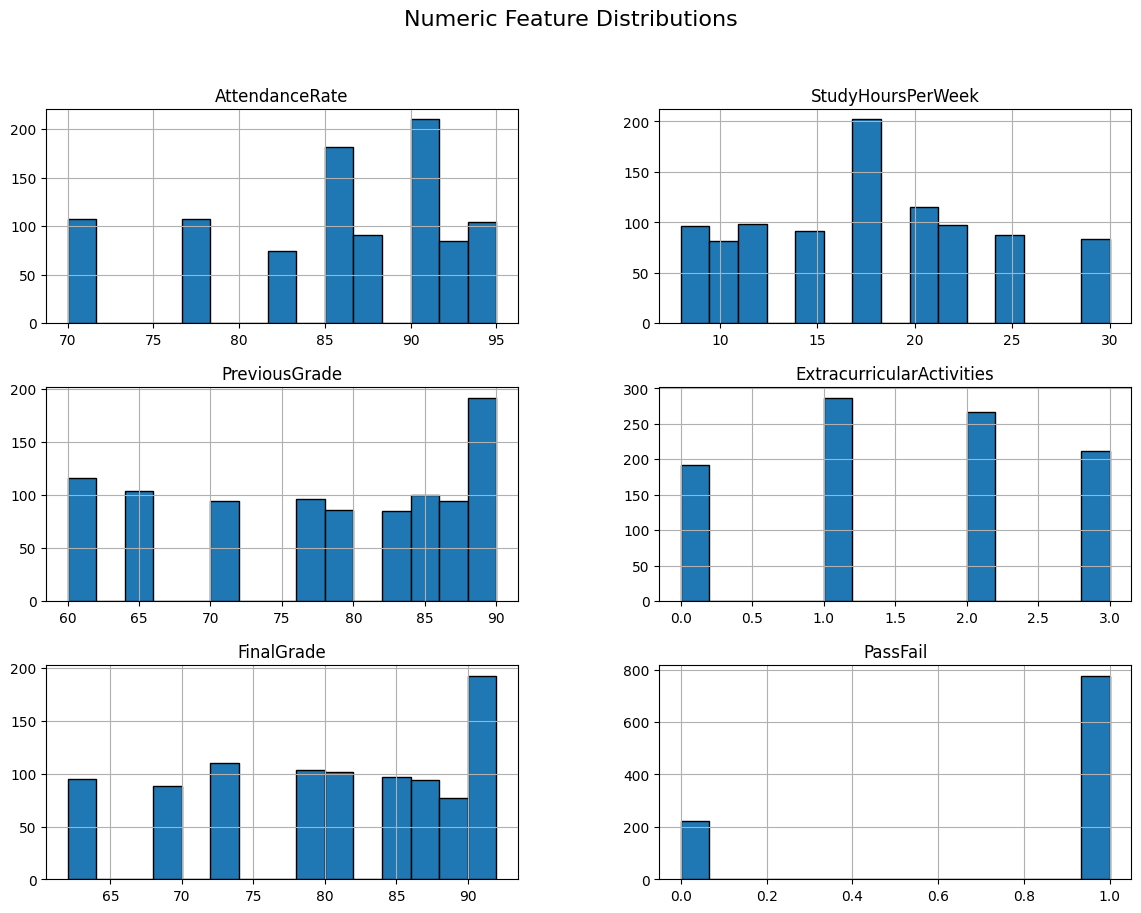

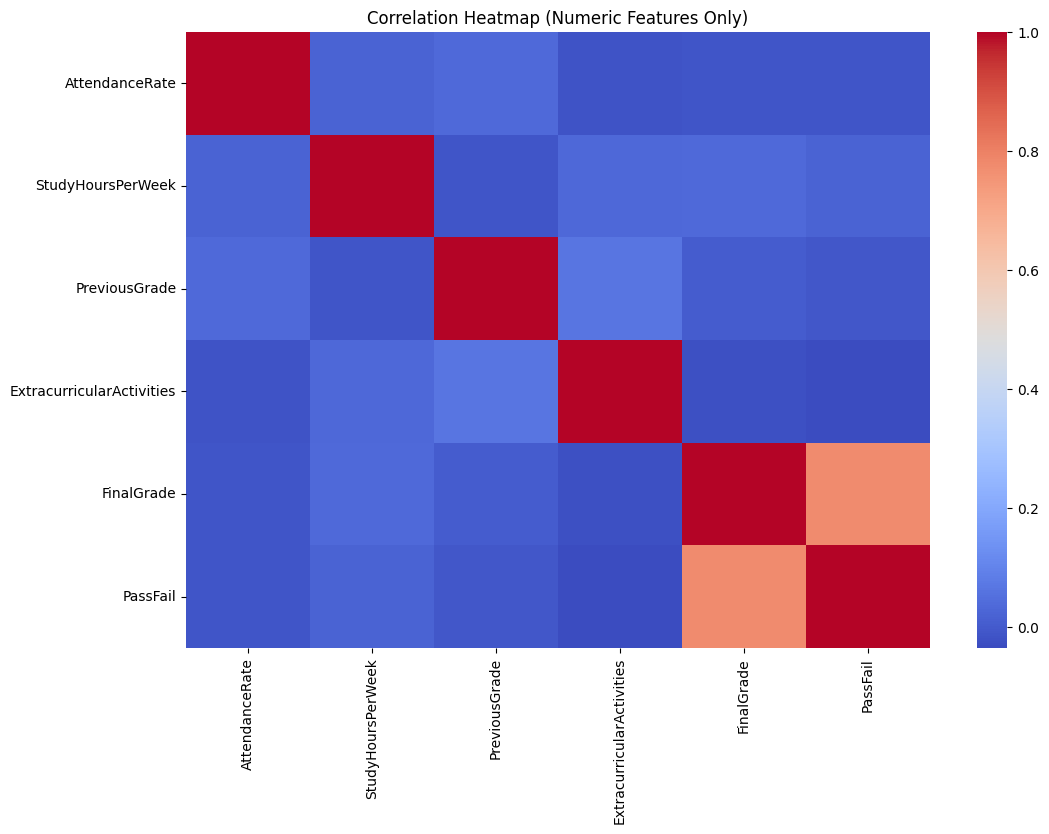

In [3]:
plt.figure(figsize=(5,4))
df["PassFail"].value_counts().plot(kind="bar", color=["red","green"])
plt.title("Pass/Fail Distribution")
plt.xticks([0,1], ["Fail", "Pass"], rotation=0)
plt.show()

numeric_cols = df.select_dtypes(include=['float64','int64']).columns
df[numeric_cols].hist(figsize=(14,10), bins=15, edgecolor='black')
plt.suptitle("Numeric Feature Distributions", fontsize=16)
plt.show()

numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()



SECTION 4: Feature Relationships

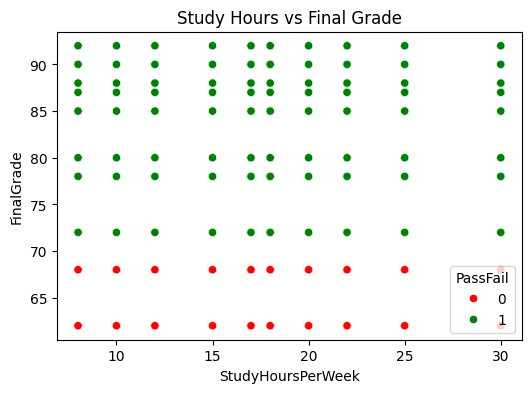

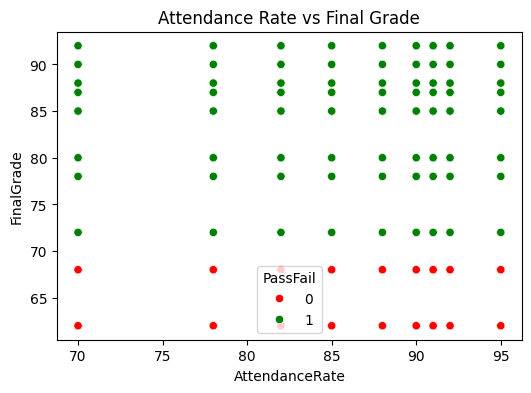

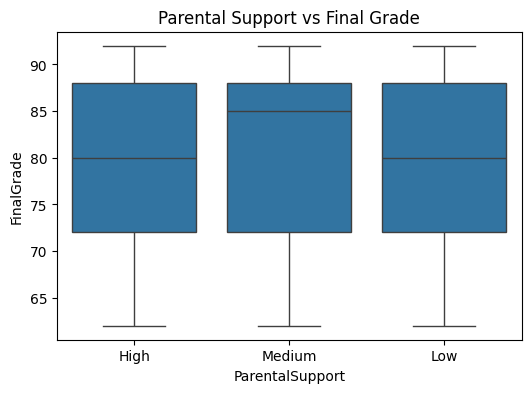

In [4]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="StudyHoursPerWeek", y="FinalGrade", hue="PassFail", palette=["red","green"])
plt.title("Study Hours vs Final Grade")
plt.show()

plt.figure(figsize=(6,4))
sns.scatterplot(data=df, x="AttendanceRate", y="FinalGrade", hue="PassFail", palette=["red","green"])
plt.title("Attendance Rate vs Final Grade")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="ParentalSupport", y="FinalGrade")
plt.title("Parental Support vs Final Grade")
plt.show()

SECTION 5: Prepare Data for Modeling

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ----- Separate Features and Target -----
X = df.drop(columns=["PassFail", "FinalGrade"])
y = df["PassFail"]

# Identify column types
numeric_features = X.select_dtypes(include=['int64','float64']).columns
categorical_features = X.select_dtypes(include=['object','bool']).columns

# Preprocessing: scale numerics, one-hot encode categoricals
from sklearn.impute import SimpleImputer

# --- Numeric preprocessing: impute -> scale ---
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# --- Categorical preprocessing: impute -> one-hot ---
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# --- Full preprocessing pipeline ---
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.head()


,Gender,AttendanceRate,StudyHoursPerWeek,PreviousGrade,ExtracurricularActivities,ParentalSupport,Online Classes Taken
593,Male,88.0,20.0,78.0,NaN,Medium,True
640,Male,90.0,10.0,82.0,2.0,NaN,True
927,Male,85.0,22.0,60.0,3.0,Medium,False
205,Female,78.0,18.0,78.0,2.0,Low,False
914,Male,70.0,10.0,88.0,0.0,Medium,True


SECTION 6 — Model Training & Evaluation

<sup>6.1 Import Modeling Tools</sup>

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns

<sup>6.2 Helper Function: Train, Predict, Evaluate</sup>

In [14]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    # Build full pipeline = preprocessing + model
    clf = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", model)
    ])
    
    # Fit
    clf.fit(X_train, y_train)
    
    # Predict
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    
    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    
    print(f"\n===== {model_name} =====")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")
    
    # Return results for ROC curve plotting
    return clf, y_prob

<sup>6.3 Train Logistic Regression</sup>

In [15]:
log_model = LogisticRegression(max_iter=200)
log_clf, log_prob = evaluate_model(
    log_model, X_train, X_test, y_train, y_test, "Logistic Regression"
)


===== Logistic Regression =====
Accuracy:  0.7750
Precision: 0.7750
Recall:    1.0000
F1 Score:  0.8732
ROC-AUC:   0.4618


<sup>6.4 Train Decision Tree</sup>

In [16]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_clf, tree_prob = evaluate_model(
    tree_model, X_train, X_test, y_train, y_test, "Decision Tree"
)


===== Decision Tree =====
Accuracy:  0.6500
Precision: 0.7742
Recall:    0.7742
F1 Score:  0.7742
ROC-AUC:   0.4982


<sup>6.5 Train Random Forest</sup>

In [17]:
rf_model = RandomForestClassifier(
    n_estimators=200, random_state=42
)

rf_clf, rf_prob = evaluate_model(
    rf_model, X_train, X_test, y_train, y_test, "Random Forest"
)


===== Random Forest =====
Accuracy:  0.7800
Precision: 0.7906
Recall:    0.9742
F1 Score:  0.8728
ROC-AUC:   0.5903


<sup>6.6 Confusion Matricies</sup>

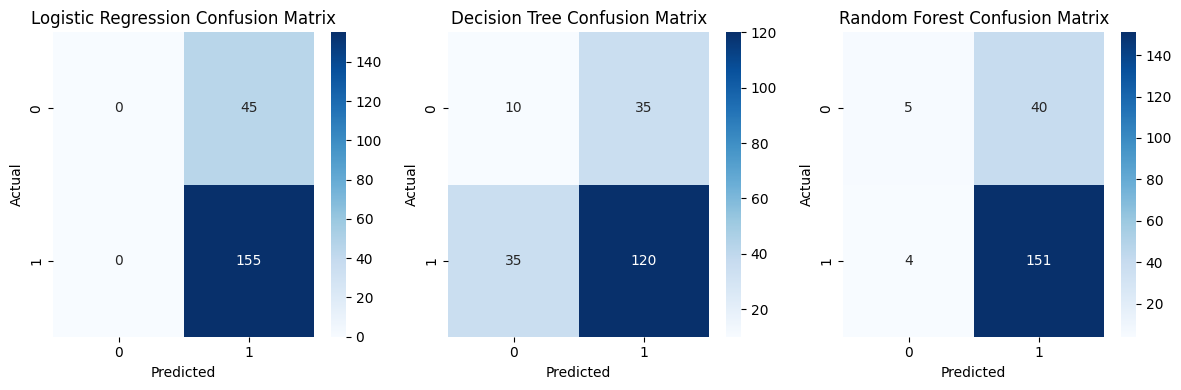

In [18]:
models = {
    "Logistic Regression": log_clf,
    "Decision Tree": tree_clf,
    "Random Forest": rf_clf
}

plt.figure(figsize=(12,4))

for i, (name, clf) in enumerate(models.items()):
    plt.subplot(1, 3, i+1)
    y_pred = clf.predict(X_test)
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt="d", cmap="Blues")
    plt.title(name + " Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


<sup>6.7 ROC Curves</sup>

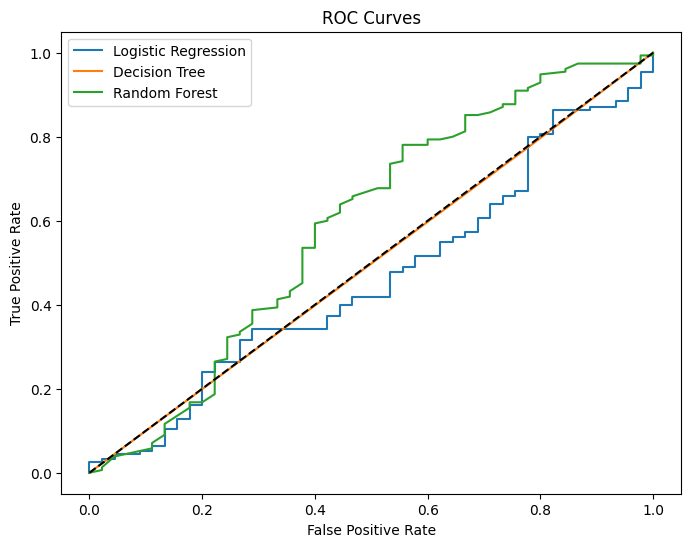

In [19]:
plt.figure(figsize=(8,6))

fpr_log, tpr_log, _ = roc_curve(y_test, log_prob)
plt.plot(fpr_log, tpr_log, label="Logistic Regression")

fpr_tree, tpr_tree, _ = roc_curve(y_test, tree_prob)
plt.plot(fpr_tree, tpr_tree, label="Decision Tree")

fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
plt.plot(fpr_rf, tpr_rf, label="Random Forest")

plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


<sup>6.8 Random Forest Feature Importance</sup>

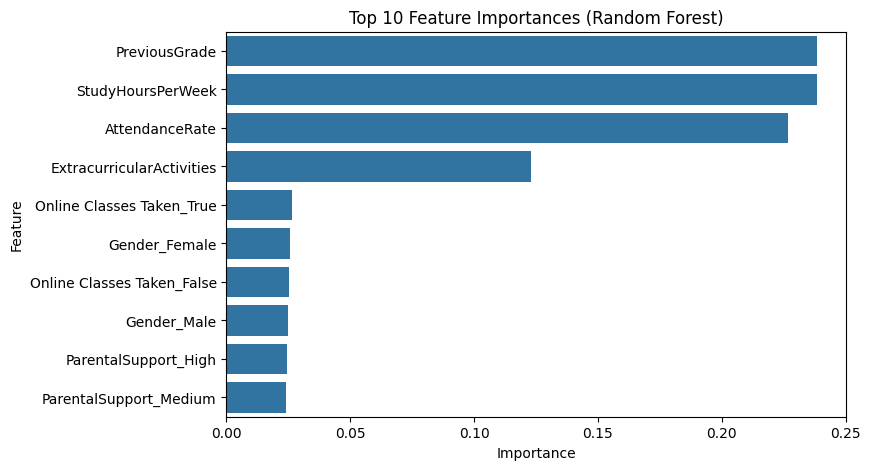

In [20]:
# Extract feature names after preprocessing
ohe = rf_clf.named_steps["preprocessor"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(categorical_features)

all_features = list(numeric_features) + list(cat_features)

# Extract importances
importances = rf_clf.named_steps["classifier"].feature_importances_

# Sort top 10 features
indices = importances.argsort()[::-1][:10]
top_features = [all_features[i] for i in indices]
top_importances = importances[indices]

plt.figure(figsize=(8,5))
sns.barplot(x=top_importances, y=top_features)
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


SECTION 7: Tuning Random Forest

<sup>7.1 Hyperparameter Tuning with GridSearchCV</sup>

In [21]:
from sklearn.model_selection import GridSearchCV

# Base RF model for tuning
rf_base = RandomForestClassifier(random_state=42)

# RF pipeline with preprocessing
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", rf_base)
])

# Light but effective search grid
param_grid = {
    "classifier__n_estimators": [200, 300],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__max_features": ["sqrt", "log2"]
}

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters Found:")
print(grid_search.best_params_)

# Evaluate tuned model
tuned_rf = grid_search.best_estimator_
tuned_rf_pred = tuned_rf.predict(X_test)
tuned_rf_prob = tuned_rf.predict_proba(X_test)[:,1]

# Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

tuned_results = {
    "Accuracy": accuracy_score(y_test, tuned_rf_pred),
    "Precision": precision_score(y_test, tuned_rf_pred),
    "Recall": recall_score(y_test, tuned_rf_pred),
    "F1": f1_score(y_test, tuned_rf_pred),
    "ROC-AUC": roc_auc_score(y_test, tuned_rf_prob)
}

print("\nTuned Random Forest Performance:")
for k,v in tuned_results.items():
    print(f"{k}: {v:.4f}")


Best Parameters Found:
{'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}

Tuned Random Forest Performance:
Accuracy: 0.7800
Precision: 0.7789
Recall: 1.0000
F1: 0.8757
ROC-AUC: 0.5746


<sup>7.2 Handling Class Imbalance</sup>

<sup>Random Forest with Class Weights</sup>

In [22]:
rf_balanced = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)

rf_balanced_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", rf_balanced)
])

rf_balanced_pipeline.fit(X_train, y_train)

bal_pred = rf_balanced_pipeline.predict(X_test)
bal_prob = rf_balanced_pipeline.predict_proba(X_test)[:,1]

balanced_results = {
    "Accuracy": accuracy_score(y_test, bal_pred),
    "Precision": precision_score(y_test, bal_pred),
    "Recall": recall_score(y_test, bal_pred),
    "F1": f1_score(y_test, bal_pred),
    "ROC-AUC": roc_auc_score(y_test, bal_prob)
}

print("\nRandom Forest (Balanced Class Weights):")
for k,v in balanced_results.items():
    print(f"{k}: {v:.4f}")



Random Forest (Balanced Class Weights):
Accuracy: 0.7650
Precision: 0.7784
Recall: 0.9742
F1: 0.8653
ROC-AUC: 0.5777


<sup>Random Forest with SMOTE Oversampling</sup>

In [23]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

smote = SMOTE(random_state=42)

rf_smote = RandomForestClassifier(
    n_estimators=300,
    random_state=42
)

smote_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("smote", smote),
    ("classifier", rf_smote)
])

smote_pipeline.fit(X_train, y_train)

smote_pred = smote_pipeline.predict(X_test)
smote_prob = smote_pipeline.predict_proba(X_test)[:,1]

smote_results = {
    "Accuracy": accuracy_score(y_test, smote_pred),
    "Precision": precision_score(y_test, smote_pred),
    "Recall": recall_score(y_test, smote_pred),
    "F1": f1_score(y_test, smote_pred),
    "ROC-AUC": roc_auc_score(y_test, smote_prob)
}

print("\nRandom Forest (SMOTE Oversampling):")
for k,v in smote_results.items():
    print(f"{k}: {v:.4f}")



Random Forest (SMOTE Oversampling):
Accuracy: 0.7450
Precision: 0.7921
Recall: 0.9097
F1: 0.8468
ROC-AUC: 0.5773


<sup>7.3 Trying Gradient-Boosted Trees (XGBoost)</sup>

In [24]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.7,
    colsample_bytree=0.7,
    eval_metric="logloss",
    random_state=42
)

xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", xgb)
])

xgb_pipeline.fit(X_train, y_train)

xgb_pred = xgb_pipeline.predict(X_test)
xgb_prob = xgb_pipeline.predict_proba(X_test)[:,1]

xgb_results = {
    "Accuracy": accuracy_score(y_test, xgb_pred),
    "Precision": precision_score(y_test, xgb_pred),
    "Recall": recall_score(y_test, xgb_pred),
    "F1": f1_score(y_test, xgb_pred),
    "ROC-AUC": roc_auc_score(y_test, xgb_prob)
}

print("\nXGBoost Model Performance:")
for k,v in xgb_results.items():
    print(f"{k}: {v:.4f}")



XGBoost Model Performance:
Accuracy: 0.7350
Precision: 0.7802
Recall: 0.9161
F1: 0.8427
ROC-AUC: 0.5864


<sup>7.4 Comparing Tuning Options vs. Default Random Forest</sup>

In [ ]:
# Re-run the baseline Random Forest using the same code as Section 6
baseline_rf = RandomForestClassifier(n_estimators=200, random_state=42)

baseline_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", baseline_rf)
])

baseline_pipeline.fit(X_train, y_train)

baseline_pred = baseline_pipeline.predict(X_test)
baseline_prob = baseline_pipeline.predict_proba(X_test)[:, 1]

baseline_results = {
    "Accuracy": accuracy_score(y_test, baseline_pred),
    "Precision": precision_score(y_test, baseline_pred),
    "Recall": recall_score(y_test, baseline_pred),
    "F1": f1_score(y_test, baseline_pred),
    "ROC-AUC": roc_auc_score(y_test, baseline_prob)
}

print("Baseline Random Forest Performance:")
for k, v in baseline_results.items():
    print(f"{k}: {v:.4f}")


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Combine results dynamically into a single structure
all_results = {
    "Baseline RF": baseline_results,
    "Tuned RF": tuned_results,
    "RF Balanced": balanced_results,
    "RF SMOTE": smote_results,
    "XGBoost": xgb_results
}

# Convert to DataFrame
comparison_df = pd.DataFrame(all_results).T

# Metric names
metrics = ["Accuracy", "Precision", "Recall", "F1", "ROC-AUC"]
num_models = len(all_results)
num_metrics = len(metrics)

x = np.arange(num_metrics)
width = 0.12  # width of each bar

plt.figure(figsize=(14,6))

# Create bars for each model
for i, model_name in enumerate(comparison_df.index):
    plt.bar(
        x + i*width,
        comparison_df.loc[model_name, metrics],
        width=width,
        label=model_name
    )

plt.xticks(x + width*(num_models-1)/2, metrics)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Comparison of Random Forest Tuning Approaches")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


NameError: name 'baseline_results' is not defined